# Tutorial 2 - Vocalist Identification & Similarity

Moving on from vocal activity detection, we now turn our attention to **vocalist identification and similarity**. The primary goal of vocalist ID is to classify an audio excerpt as belonging to one person in a known set of singers. 

Why is this a worthwhile pursuit? On the face of it, vocalist ID presents an interesting machine listening challenge, and one with an objective definition of ground truth, e.g. singer $X$ produced recording $Y$. More generally, however, this information (recordings tied to specific vocalists) can be used to learn an acoustic embedding for **similarity and retrieval.** In other words, by building a system that can organize sound so that vocal recordings can be reliably classified, representations learned by that system can be used for nearest neighbor search.

To these ends, this notebook demonstrates how to build an acoustic embedding model using a vocalist identification as a proxy for similarity. In this example, you will download a large dataset of isolated vocal recordings, compute time-varying features, train a machine learning model to classify voice, *modify* that model to produce embeddings, evaluate the reliability of the system, and use it to do a sound-alike search.

### Contents
0. [Getting the Data](#Getting-the-Data)
1. [Feature Extraction](#Feature-Extraction)
2. [Data Sampling](#Data-Sampling)
3. [Baseline Machine Learning](#Baseline-Machine-Learning)
4. [Designing an Embedding Model](#Designing-an-Embedding-Model)
5. [Summary](#Summary)


In [1]:
# All libraries used in this notebook
import collections, glob, itertools, keras, librosa
import mir_eval, os, pescador, sklearn, tqdm

from IPython.display import Audio, HTML, display
from joblib import Parallel, delayed
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.ensemble
import soundfile as sf

%matplotlib inline

Using TensorFlow backend.


## Getting the Data

In this notebook, we use a dataset compiled from Smule's *Sing!* Karaoke. *Sing!* is a mobile app that enables players to sing vocal tracks to popular music. This is great for vocal research, because it creates a number of recordings per vocalist, from many different vocalists of varying skills. 

Smule generously makes these tracks available for educational, non-commercial purposes, which you can find [online at Zenodo](https://zenodo.org/record/2533419). To download the data, you will have to accept the license terms and request access -- once approved by our friends at Smule, you'll be notified that you're clear to download the dataset. 

This dataset, dubbed the `DAMP-VP1k`, contains 1000 audio recordings drawn from 100 vocalists (10 each). Once you've been granted access, download and extract it to a location on disk; we'll refer to this as the dataset root, or `DATA_ROOT` below. Before running the following cell, update the path to where you've extracted the dataset.

The audio files are named with the convention `{plyr_id}_{rec_id}`, where `plyr_id` represents a unique ID for a user, and `rec_id` is a unique ID for the recording. Thus all recordings with the same prefix (`plyr_id`) come from the same user. 

Note, of course, that Sing! is a karaoke app that produces user-generated content – it is not difficult to find instances of people sharing acounts, singing duets, or any number of things that violate the assumption that `plyr_id` corresponds to a single, consistent vocalist. **Importantly**, the subset we use here has been manually vetted (lightly) to find 100 consistent solo singers. If you want **all** the data, you should follow instructions to get the [multiple performances dataset](https://ccrma.stanford.edu/damp/), which totals over 40GB.

In [2]:
# Update `DATA_ROOT` to match the expanded location of the dataset.
DATA_ROOT = '/Users/ejhumphrey/data/ieee-spm-vox-tutorial/damp-vp1k/'
AUDIO = os.path.join(DATA_ROOT, 'audio')

# We'll write feature data here
FEATURES = os.path.join(DATA_ROOT, 'features')

if not os.path.exists(FEATURES):
    os.makedirs(FEATURES)

## Feature Extraction

We'll use a similar routine as the previous example to compute MFCC features over the collection of audio. 

Note that instead the "label" is specified by the basename of the file, and so there is no additional label information that needs to be included in the NPZ object we save to disk.

In [3]:
def compute_features(af, n_fft, hop_length, n_mfcc, skip_existing=True):
    filebase = os.path.splitext(os.path.basename(af))[0]
    output_file = os.path.join(FEATURES, '{}.npz'.format(filebase))
    if os.path.exists(output_file) and skip_existing:
        return
        
    y, sr = sf.read(af)
    if y.ndim == 2:
        y = y.mean(axis=1)
    
    # Transpose to be time-major (rows)
    X = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, 
                             n_fft=n_fft, hop_length=hop_length).T

    time = librosa.frames_to_time(frames=np.arange(len(X)), 
                                  hop_length=hop_length, n_fft=n_fft, sr=sr)
    
    np.savez(output_file, mfcc=X, time=time)

In [4]:
# Compute MFCCs and write to disk. 
# Using four cores on a new MacBook Air, takes ≈5min
hop_length = 512
n_fft = 1024
n_mfcc = 20

audio_files = glob.glob(os.path.join(AUDIO, '*.ogg'))

dfx = delayed(compute_features)
pool = Parallel(n_jobs=-1, verbose=1)
pool(dfx(af, n_fft, hop_length, n_mfcc) for af in audio_files)

audio_files, feature_files = mir_eval.util.intersect_files(
    audio_files, glob.glob(os.path.join(FEATURES, '*npz')))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.2s finished


In [5]:
# Let's take a look at MFCCs vs the audio waveform
file_idx = 10

with np.load(feature_files[file_idx]) as data:
    feats = data['mfcc']
    time = data['time']

audio_file = audio_files[file_idx]

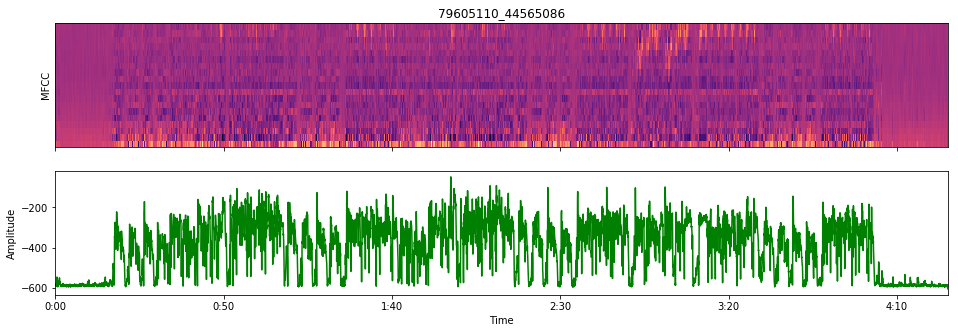

In [6]:
# Display the features against the reference annotation
fig, axes = plt.subplots(2, 1, figsize=(16, 5), sharex=True)

# Drop the first coefficient (amplitude) for visualization
_, sr = sf.read(audio_file)
librosa.display.specshow(feats.T[1:], sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='off', ax=axes[0], cmap='magma')
axes[0].set_ylabel("MFCC")
axes[1].plot(time, feats.T[0], 'g')
axes[1].set_ylabel("Amplitude")

# Display tweaks
filebase = os.path.splitext(os.path.basename(audio_file))[0]
for ax, xlabel, title in zip(axes, ['', 'Time'], [filebase, '']):
    ax.set_xlabel(xlabel)
    ax.set_title(title)

display(Audio(filename=audio_file))

### Discussion

Having visualized the MFCC features for a given singer, we can clearly see how the first coefficient represents time-varying loudness of the recording. When we fit our model though, we'll want to omit all instances where the recording is silent, as these observations aren't reflective of the actual vocalist and should be treated as "noisy" (or mislabeled) observations. 

But how do we define silence? To do this in a principled manner, we can compute a global historgram of the first MFCC, and manually pick a good crossover point between "silence" and "singing", which should reveal itself in the visualization.

In [7]:
# Collect all amplitudes
amplitudes = []

for feature_file in tqdm.tqdm_notebook(feature_files):
    with np.load(feature_file) as data:
        amplitudes += [np.array(data['mfcc'].T[0])]

Text(0.5, 0, 'MFCC[0] Amplitude')

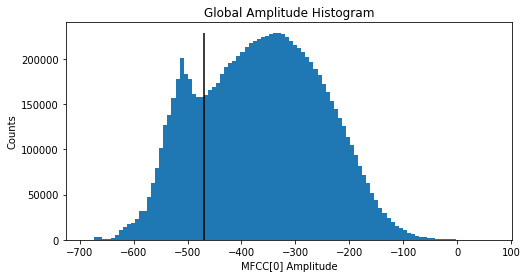

In [8]:
# Plot the histogram to identify a sane global amplitude threshold
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
bins, edges, handles = plt.hist(np.concatenate(amplitudes), bins=100)

# Feel free to pick a different loudness threshold!
# Note that this value is used below.
threshold = edges[29] 

plt.vlines(threshold, ymin=0, ymax=bins.max())
ax.set_title('Global Amplitude Histogram')
ax.set_ylabel('Counts')
ax.set_xlabel('MFCC[0] Amplitude')

Sure enough, when we've taken the histogram of amplitudes, we can see a bimodal distribution between silence and singing. Here, we set a `threshold` parameter corresponding to the edge of the upper mode; the specific value doesn't matter *too* much, since the motivation is primarily to reduce the amount of noisy datapoints we'll use during training and evaluation.

## Data Sampling

Similar to the VAD example, we'll now write a generator to randomly draw samples from a longer feature sequence. There are two notable changes from before.

First, we'll use the name of the file to generate the label for each data point. All samples produced by a given generator will have the same label, since they're all drawn from the same recording.

Second, a `threshold` parameter is specified so that samples with an amplitude coefficient below this value won't be sampled. This way, only sufficiently "loud" observations are returned by the sampler.

In [9]:
def sampler(npz_file, num_frames, threshold, random_state=None):
    with np.load(npz_file) as data:
        mfcc = np.array(data['mfcc'])
        time = np.array(data['time'])
    
    perf_id = os.path.splitext(os.path.basename(npz_file))[0]
    player_id = perf_id.split('_')[0]
    
    # Build an index for centered observations
    idx = np.arange(len(mfcc))[num_frames // 2: -num_frames // 2]
    
    # Drop the indices that aren't "loud" enough
    idx = idx[mfcc[num_frames // 2: -num_frames // 2, 0] >= threshold]
    
    # Create a random state object and shuffle the index
    rng = np.random.RandomState(random_state)
    rng.shuffle(idx)
    counter = 0

    while True:
        sample_key = '{}_{}'.format(perf_id, int(0.5 + time[idx[counter]]*1000))
        i0 = idx[counter] - num_frames // 2
        i1 = i0 + num_frames
        # Force the array copy
        yield np.array(mfcc[i0:i1, :]), player_id, sample_key

        counter += 1
        if counter == len(idx):
            counter = 0
            rng.shuffle(idx)

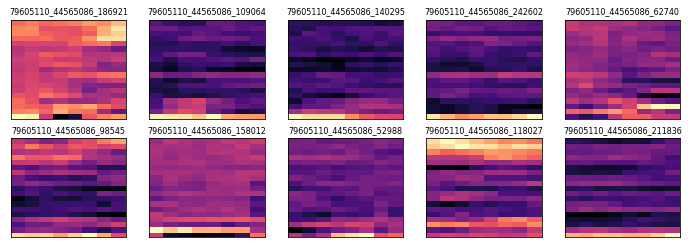

In [10]:
# Let's visualize a handful of samples
gen = sampler(feature_files[10], 8, threshold)
fig, axes = plt.subplots(2, 5, figsize=(12, 4), sharex=True, sharey=True)

for ax, (x, y, k) in zip(axes.flatten(), gen):
    librosa.display.specshow(x.T[1:], sr=sr, hop_length=hop_length, 
                             x_axis='off', y_axis='off', ax=ax, cmap='magma')
    ax.set_title(k, fontsize=8)

### Sampling data points for machine learning

Like the previous example, we'll want to produce a collection of samples (X) and labels (Y) so that we can easily fit and evaluate a machine learning model. 

The first step is to partition the audio files into a training and test set. This process is slightly different from before, because we need to group all the recordings by vocalist, putting one in the test set and using the rest for training. 

In [11]:
train_files, test_files = [], []
vocalist_map = {}

def filename_to_plyrid(fn):
    return os.path.basename(fn).split('_')[0]

for vocalist_id, filegroup in itertools.groupby(sorted(feature_files), filename_to_plyrid):
    filenames = list(filegroup)
    train_files.extend(filenames[:-1])
    test_files.append(filenames[-1])
    vocalist_map[vocalist_id] = len(vocalist_map)

np.random.shuffle(train_files)

In [12]:
num_frames = 64
num_train_samples = 100000

train_stream = pescador.ShuffledMux(
    [pescador.Streamer(sampler, feature_file, num_frames, threshold)
     for feature_file in train_files])

X_train, Y_train, K_train = [], [], []
for x, y, k in tqdm.tqdm_notebook(train_stream.iterate(max_iter=num_train_samples)):
    X_train += [x]
    Y_train += [y]
    K_train += [k]

X_train = np.array(X_train)
Yi_train = np.array([vocalist_map[y] for y in Y_train])
print(X_train.shape, Yi_train.shape)


(100000, 64, 20) (100000,)


In [13]:
num_test_samples = 10000

test_stream = pescador.ShuffledMux(
    [pescador.Streamer(sampler, feature_file, num_frames, threshold)
     for feature_file in test_files])

X_test, Y_test, K_test = [], [], []
for x, y, k in tqdm.tqdm_notebook(test_stream.iterate(max_iter=num_test_samples)):
    X_test += [x]
    Y_test += [y]
    K_test += [k]

X_test = np.array(X_test)
Yi_test = np.array([vocalist_map[y] for y in Y_test])
print(X_test.shape, len(Yi_test))


(10000, 64, 20) 10000


In [14]:
# Make sure that the sampled data makes sense!
train_counts = collections.Counter(Y_train)
test_counts = collections.Counter(Y_test)

# Should be 100!
print(len(set(train_counts.keys()).intersection(set(test_counts.keys()))) == 100)

True


In [15]:
# Reduce the dimensionality of the input data, and scale (whiten) it 
# according to its eigenvectors.
n_components = 64
pca = sklearn.decomposition.PCA(n_components=n_components, whiten=True)
pca.fit(X_train[:, :, 1:].reshape(-1, 19 * num_frames))
Z_train = pca.transform(X_train[:, :, 1:].reshape(-1, 19 * num_frames))
Z_test = pca.transform(X_test[:, :, 1:].reshape(-1, 19 * num_frames))

In [16]:
# Fit a few baseline classifiers
# Note that the Logistic Regression model takes north of 4min
clfs = [
    sklearn.linear_model.LogisticRegressionCV(verbose=True, max_iter=100, 
                                              cv=3, multi_class='multinomial', n_jobs=-1),
    sklearn.ensemble.RandomForestClassifier(n_estimators=10)]

for clf in clfs: 
    clf.fit(Z_train, Yi_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.9min finished


In [17]:
print('   Train  Test')
for name, clf in zip(['LR', 'RF'], clfs): 
    print('{} {:0.3f} {:0.3f}'
          .format(name, clf.score(Z_train, Yi_train), 
                  clf.score(Z_test, Yi_test)))

   Train  Test
LR 0.475 0.325
RF 0.999 0.150


## Designing an Embedding Model

In order to learn an embedding by way of a classification task, we can use a multi-layer neural network to classify observations, and use the penultimate (second to last) layer's output as an embedding.

Here we use two dense (fully-connected) layers with dropout regularization to do the heavy lifting of disentangling the features, and a smaller "bottleneck" layer with a linear activation as our embedding. This approach has proven useful in a number of other deep learning heavy domains, such as speech or image processing. The intuition behind this architecture is that multiple high-dimensional layers transform the data into a representation that *is* linearly separable by the final multinomial logistic layer.

In [18]:
x_in = keras.layers.InputLayer(input_shape=(n_components,))
layer0 = keras.layers.Dense(256, activation='relu')
dropout0 = keras.layers.Dropout(0.5)
layer1 = keras.layers.Dense(256, activation='relu')
dropout1 = keras.layers.Dropout(0.5)
layer2 = keras.layers.Dense(20, activation='linear')
layer3 = keras.layers.Dense(100, activation='softmax')

embedding = keras.Sequential([x_in, layer0, dropout0, layer1, dropout1, layer2])
dnn = keras.Sequential([x_in, layer0, dropout0, layer1, dropout1, layer2, layer3])
dnn.compile('Adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                5140      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               2100      
Total params: 89,672
Trainable params: 89,672
Non-trainable params: 0
_________________________________________________________________


Now we'll train the model for a number of epochs. Again, in the interest of time, we're not aiming for the best possible performance, only that the model has learned something of value.

Of course, if you'd like to train the model for longer, you are welcome to it!

Note that by sharing the same layer objects in both the `embedding` and `dnn` networks, we can call the `dnn`'s fit method and it will update the underlying weights used in the `embedding` network.

In [19]:
history = dnn.fit(Z_train, Yi_train, epochs=10)

Epoch 1/10
100000/100000 [==============================] - 10s 103us/step - loss: 3.2030 - acc: 0.2143
Epoch 2/10
100000/100000 [==============================] - 10s 100us/step - loss: 2.5783 - acc: 0.3358
Epoch 3/10
100000/100000 [==============================] - 10s 103us/step - loss: 2.4470 - acc: 0.3641
Epoch 4/10
100000/100000 [==============================] - 10s 98us/step - loss: 2.3658 - acc: 0.3809
Epoch 5/10
100000/100000 [==============================] - 10s 99us/step - loss: 2.3067 - acc: 0.3959
Epoch 6/10
100000/100000 [==============================] - 10s 100us/step - loss: 2.2702 - acc: 0.4024
Epoch 7/10
100000/100000 [==============================] - 10s 100us/step - loss: 2.2451 - acc: 0.4060
Epoch 8/10
100000/100000 [==============================] - 10s 99us/step - loss: 2.2189 - acc: 0.4126
Epoch 9/10
100000/100000 [==============================] - 11s 106us/step - loss: 2.2012 - acc: 0.4184
Epoch 10/10
100000/100000 [==============================] - 10s 97

In [20]:
print('Train Accuracy', (dnn.predict_classes(Z_train) == Yi_train).mean())
print('Test Accuracy', (dnn.predict_classes(Z_test) == Yi_test).mean())

Train Accuracy 0.58916
Test Accuracy 0.3693


### Discussion

As you can see from the discrepancy between training and test partitions, the model is overfitting the training set (by about 20%). That said, keep in mind that with 100 different vocalists, a random classifier would be correct just 1% of the time, so the model is certainly learning something! 

Now let's use it as an embedding model to see how well it may work for vocal similarity.

In [21]:
C_train = embedding.predict(Z_train)
C_test = embedding.predict(Z_test)

In [22]:
def clip_audio(sample_key, time_context):
    perf_id = '_'.join(sample_key.split('_')[:2])
    time_ms = int(sample_key.split('_')[-1])
    audio_file = os.path.join(AUDIO, '{}.ogg'.format(perf_id))
    x, sr = sf.read(audio_file)
    i0 = int(0.5 + time_ms / 1000 * sr - time_context * sr)
    return dict(data=np.array(x[i0:i0 + int(time_context * 2 * sr)]), rate=sr)

In [23]:
nns = sklearn.neighbors.NearestNeighbors(n_jobs=-1, metric='cosine').fit(C_train, K_train)

In [24]:
# Pick a random datapoint's index in the test set
idx = np.random.randint(len(Yi_test))

n_results = 5  # Number of examples to return
time_context = 0.75  # seconds before / after

# Display query
print('Query Clip: {}'.format(K_test[idx]))
display(Audio(**clip_audio(K_test[idx], time_context)))

print('Results\n=================')
for i, n in enumerate(nns.kneighbors(C_test[idx].reshape(1, -1), 
                                     n_neighbors=n_results, return_distance=False)[0], 1):
    print('Rank {}: {}'.format(i, K_train[n]))
    display(Audio(**clip_audio(K_train[n], time_context)))

Query Clip: 90470919_47190349_32903


Results
Rank 1: 166934090_34312497_44652


Rank 2: 156974966_34659090_10263


Rank 3: 114904872_28665316_44048


Rank 4: 124657556_24741740_140968


Rank 5: 79605110_39382566_89397


## Summary

In this tutorial, we've used a classification task (vocalist identification) to train an acoustic embedding model, which can then be used to map new sounds into a low(er) dimensional space for efficient nearest-neighbor computation. 

* Extracted MFCC features
* Determined a silence threshold through a global histogram
* Defined sample generators that yield windowed observations with labels from the data
* Sampled a large collection into a training and test set to fit our models
* Performed Principal Components Analysis (PCA) to scale the data
* Fit a few different machine learning models
* Computed accuracy / error over the train/test partitions
* Shared parameters from a deep classification model to embed samples
* Used a nearest neighbor model to query by example

## Where to go next?




### 1. Different Features, Different Models

As in the previous notebook, we're using basic feature representations and modeling decisions.  There is a wide range of parameters to explore in this example as well.


### 2. Model Longer Timescales

For simplicity, we've mapped slightly longer time-scales (1.5s) into a ZCA feature space. We're able to get slightly better performance with a deeper network than the Logistic Regression model, but this pre-processing is likely limiting the more powerful models from learning better representations. Try to preserve the time dimension from the sampled features, and use a convolutional or recurrent model to learn temporal features.


### 3. More Extensive Evaluation

We've taken a brief look at the accuracy of the trained classifier, but it is also possible to test the Nearest Neighbor classifier in the embedding space. While it is safe to assume that the learned embedding space should outperform the PCA embedding, try to compare these two. Additionally, we can treat query-by-example as a ranked retrieval problem, and look at metrics such as precision / recall at $k$, area under the ROC curve (AUC score), mean-average precision, etc.


### 4. Embedding Generalization

An advantageous property of acoustic embeddings is that once the model is trained, arbitrary audio can be embedded into the same representation. Therefore, while the classifier is limited to the known vocalists, the embedding space can represent all solo voice in the dataset. Try mapping the full collection into this embedding and finding similar sound snippets to a recording of your own voice!